In [2]:
import pandas as pd

In [5]:
lit_df = pd.read_excel('../data/polymer-degradation/literature.xlsx')
exp1_df = pd.read_excel('../data/polymer-degradation/exp1.xlsx')
exp2_df = pd.read_excel('../data/polymer-degradation/exp2.xlsx')

In [7]:
lit_df.head()

,Name,SMILES,Degradability
0,PET,*CCOC(=O)c1ccc(cc1)C(=O)O*,0.00030
1,PLA,*OC(C)C(=O)*,0.00033
2,PLLA,*C([C@H](O*)C)=O,0.00140
3,PCL,*CCCCCC(=O)O*,0.00270
4,PS,*CC(*)c1ccccc1,0.01110


In [8]:
exp1_df.head()

,Name,SMILES,Degradability
0,Poly(hexamethylene sebacate),*CCCCCCOC(=O)CCCCCCCCC(=O)O*,0.000646
1,Poly(vinyl butyral),*CC1CC(*)OC(CCC)O1,0.000586
2,Poly(benzyl acrylate),*CC(*)C(=O)OCc1ccccc1,0.000369
3,Poly(isodecyl acrylate),*CC(*)C(=O)OCCCCCCCC(C)C,0.000304
4,Poly(isopropyl acrylate),*CC(*)C(=O)OC(C)C,0.000220


In [28]:
import numpy as np
from gensim.models import word2vec
from mol2vec.features import (
    DfVec,
    MolSentence,
    mol2alt_sentence,
    sentences2vec,
)
from rdkit import Chem

smiles = "CCC"
model = word2vec.Word2Vec.load("../data/polymer-degradation/model_300dim.pkl")
mols = [Chem.MolFromSmiles(smiles)]
mol_sentence = [MolSentence(mol2alt_sentence(mol, 1)) for mol in mols] 
x_molvec = [DfVec(x) for x in sentences2vec(mol_sentence, model, unseen="UNK")]
x_molvec = np.array([x.vec for x in x_molvec])

[09:06:44] DEPRECATION WARNING: please use MorganGenerator


In [29]:
x_molvec

array([[-0.06510311,  0.6038942 , -0.40993994,  0.43479457,  0.85205245,
         0.01044187, -1.4227272 , -0.42066723,  0.6476414 , -0.7450533 ,
        -0.3969116 ,  0.14799254,  1.0832216 ,  0.7870382 , -0.82985926,
        -0.61802316,  1.1716034 , -0.16003601,  0.05306735,  1.4131069 ,
        -0.8396008 ,  0.22364607,  2.0650606 ,  1.7489554 , -1.3958741 ,
        -0.37809995, -0.44391614, -1.0678691 ,  0.6351455 , -0.13093117,
         0.21922696,  0.0649571 , -1.0547262 , -1.0655241 , -0.40664828,
        -0.47988826, -0.229142  , -0.31137484,  1.1777065 ,  1.224853  ,
         0.020955  , -0.19645074,  0.17041464, -0.9942696 , -1.1044811 ,
         0.30828944, -0.30312097,  1.5911225 ,  0.32077798,  0.42821234,
        -0.8467165 , -1.1586841 ,  1.3061452 , -0.30000126, -1.6529086 ,
        -0.84454846, -0.4567191 ,  0.89597803, -0.3931036 , -0.19177876,
        -0.55236226,  0.08921518, -0.79358673, -0.5296779 , -1.9005053 ,
        -0.8078085 ,  0.405052  , -0.22353503, -1.1

In [31]:
def mol2vec(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    model = word2vec.Word2Vec.load("../data/polymer-degradation/model_300dim.pkl")
    mol_sentence = [MolSentence(mol2alt_sentence(mol, 1)) for mol in mols] 
    x_molvec = [DfVec(x) for x in sentences2vec(mol_sentence, model, unseen="UNK")]
    x_molvec = np.array([x.vec for x in x_molvec])
    return x_molvec

X = mol2vec(['CCC', 'CCO', 'CCN'])
X.shape

[09:08:53] DEPRECATION WARNING: please use MorganGenerator
[09:08:53] DEPRECATION WARNING: please use MorganGenerator
[09:08:53] DEPRECATION WARNING: please use MorganGenerator


(3, 300)

In [32]:
def create_pairwise_preferences(X, y):
    n_samples = X.shape[0]
    pairwise_X = []
    pairwise_y = []
    
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            if y[i] != y[j]:
                x_diff = X[i] - X[j]
                pairwise_X.append(x_diff)
                pairwise_y.append(1 if y[i] > y[j] else -1)
                pairwise_X.append(-x_diff)
                pairwise_y.append(-1 if y[i] > y[j] else 1)
    
    return np.array(pairwise_X), np.array(pairwise_y)

In [35]:
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

In [44]:
X_lit = mol2vec(lit_df['SMILES'])
y_lit = lit_df['Degradability'].values
pairwise_X_lit, pairwise_y_lit = create_pairwise_preferences(X_lit, y_lit)

X_exp1 = mol2vec(exp1_df['SMILES'])
y_exp1 = exp1_df['Degradability'].values
pairwise_X_exp1, pairwise_y_exp1 = create_pairwise_preferences(X_exp1, y_exp1)

X_exp2 = mol2vec(exp2_df['SMILES'])
y_exp2 = exp2_df['Degradability'].values
pairwise_X_exp2, pairwise_y_exp2 = create_pairwise_preferences(X_exp2, y_exp2)

In [46]:
print(pairwise_X_lit.shape)
print(pairwise_X_exp1.shape)
print(pairwise_X_exp2.shape)

(550, 300)
(42, 300)
(56, 300)


In [76]:
X_pw_train = np.concatenate([pairwise_X_lit, pairwise_X_exp1])
y_pw_train = np.concatenate([pairwise_y_lit, pairwise_y_exp1])


In [157]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1, dual=False, max_iter=10000)
svm.fit(X_pw_train, y_pw_train)

LinearSVC(C=1, dual=False, max_iter=10000)

In [158]:
y_train_pred = svm.predict(X_pw_train)

In [159]:
def evaluate_ranking(X_test, y_test, svm):
    n_samples = X_test.shape[0]
    scores = np.zeros(n_samples)
    for i in range(n_samples):
        for j in range(n_samples):
            if i != j:
                diff = X_test[i] - X_test[j]
                score = svm.decision_function([diff])[0]
                scores[i] += score
    predicted_ranks = (-scores).argsort().argsort()
    true_ranks = (-y_test).argsort().argsort()
    
    return predicted_ranks, true_ranks

In [160]:
pred_ranks_lit, true_ranks_lit = evaluate_ranking(X_lit, y_lit, svm)
pred_ranks_exp1, true_ranks_exp1 = evaluate_ranking(X_exp1, y_exp1, svm)
pred_ranks_exp2, true_ranks_exp2 = evaluate_ranking(X_exp2, y_exp2, svm)

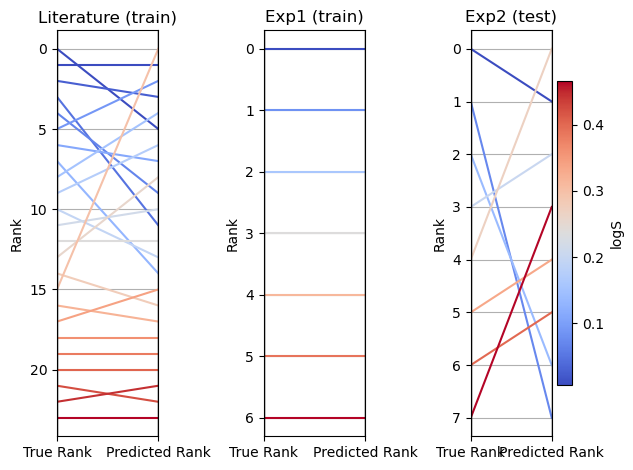

In [161]:
import matplotlib.pyplot as plt

plot_items = {
    "Literature (train)":{
        'True Rank': true_ranks_lit,
        'Predicted Rank': pred_ranks_lit,
        "logS": y_lit
    },
    "Exp1 (train)":{
        'True Rank': true_ranks_exp1,
        'Predicted Rank': pred_ranks_exp1,
        "logS": y_exp1
    },
    "Exp2 (test)":{
        'True Rank': true_ranks_exp2,
        'Predicted Rank': pred_ranks_exp2,
        "logS": y_exp2
    }
}

fig = plt.figure()

for i, (key, item) in enumerate(plot_items.items()):
    ax = fig.add_subplot(1, 3, i+1)
    df_plot = pd.DataFrame(item)
    n_samples = len(df_plot)
    df_plot = df_plot.sort_values('True Rank')

    pl = pd.plotting.parallel_coordinates(df_plot, 'logS', colormap=plt.cm.coolwarm, ax=ax)

    ax.set_title(f"{key.capitalize()}")

    ax.set_ylabel('Rank')
    ax.invert_yaxis()
    ax.get_legend().remove()

    if i == 2:
        norm = plt.Normalize(df_plot['logS'].min(), df_plot['logS'].max())
        sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax)
        cbar.set_label('logS')
    
fig.tight_layout()

In [162]:
from scipy.stats import kendalltau, spearmanr
from sklearn.metrics import ndcg_score


def evaluate_ranking_metrics(true_ranks, predicted_ranks):
    metrics = {}
    
    # 1. Spearman's Rank Correlation Coefficient
    spearman_corr, _ = spearmanr(true_ranks, predicted_ranks)
    metrics['spearman_correlation'] = spearman_corr
    
    # 2. Kendall's Tau
    kendall_tau, _ = kendalltau(true_ranks, predicted_ranks)
    metrics['kendall_tau'] = kendall_tau
    
    # 3. Mean Reciprocal Rank (MRR)
    def mrr(true_ranks, predicted_ranks):
        sorted_indices = np.argsort(predicted_ranks)
        true_ranks_sorted = true_ranks[sorted_indices]
        rr = 1.0 / (np.argwhere(true_ranks_sorted == 0)[0][0] + 1)
        return rr
    
    metrics['mrr'] = mrr(true_ranks, predicted_ranks)
    
    # 4. Normalized Discounted Cumulative Gain (NDCG)
    # Note: sklearn's ndcg_score expects relevance scores, not ranks
    relevance_scores = len(true_ranks) - true_ranks  # Convert ranks to relevance scores
    metrics['ndcg'] = ndcg_score([relevance_scores], [predicted_ranks])
    
    # 5. Precision at k
    def precision_at_k(true_ranks, predicted_ranks, k):
        top_k_predicted = np.argsort(predicted_ranks)[:k]
        top_k_true = np.argsort(true_ranks)[:k]
        return len(set(top_k_predicted) & set(top_k_true)) / k
    
    metrics['precision_at_5'] = precision_at_k(true_ranks, predicted_ranks, 5)
    metrics['precision_at_10'] = precision_at_k(true_ranks, predicted_ranks, 10)
    
    return metrics

In [163]:
metrics = evaluate_ranking_metrics(true_ranks_lit, pred_ranks_lit)
metrics

{'spearman_correlation': 0.7956521739130433,
 'kendall_tau': 0.6521739130434783,
 'mrr': 0.16666666666666666,
 'ndcg': 0.6613718179338621,
 'precision_at_5': 0.4,
 'precision_at_10': 0.8}

In [164]:
metrics = evaluate_ranking_metrics(true_ranks_exp1, pred_ranks_exp1)
metrics

{'spearman_correlation': 1.0,
 'kendall_tau': 1.0,
 'mrr': 1.0,
 'ndcg': 0.6906586576709706,
 'precision_at_5': 1.0,
 'precision_at_10': 0.7}

In [165]:
metrics = evaluate_ranking_metrics(true_ranks_exp2, pred_ranks_exp2)
metrics

{'spearman_correlation': -0.04761904761904763,
 'kendall_tau': -0.07142857142857142,
 'mrr': 0.5,
 'ndcg': 0.9057999306381667,
 'precision_at_5': 0.6,
 'precision_at_10': 0.8}